# DAIDEC challange

# Machine Learning Modelling
For the creation of the binary classifier, various algorithms were tested such as Logistic Regression, K-Nearest Neighbors and Support Vector Machines. However, their accuracy were below 70%.

The highest accuracy (about ~73%) cames from the XGBoost clasifier that is mentioned here. 

The XGBoost Classifier wes used for the modelling along with the scikit-earn library for data preprocessing, metrics and model selection. 

The one-hot encoding was applied to low-cardinality categorical features, as it is typical in machine learning. The high-cardinality features were dealt like numerical data.

The StandardScaler function was used to to scale numerical features. 

The train_test_split function was employed to split the dataset.


In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb


In [2]:
dataset_0 = pd.read_csv('clean_dataset.csv')
dataset_0.count()

agency_code                       6944633
loan_type                         6944633
property_type                     6944633
owner_occupancy                   6944633
loan_amount_000s                  6944633
action_taken                      6944633
msamd                             6944633
state_code                        6944633
county_code                       6944633
census_tract_number               6944633
applicant_ethnicity               6944633
applicant_race_1                  6944633
applicant_sex                     6944633
applicant_income_000s             6944633
lien_status                       6944633
population                        6944633
minority_population               6944633
hud_median_family_income          6944633
tract_to_msamd_income             6944633
number_of_owner_occupied_units    6944633
number_of_1_to_4_family_units     6944633
dtype: int64

In [3]:
cat_cols_few = ["loan_type", "property_type", "owner_occupancy", "agency_code", 
                "lien_status", "applicant_ethnicity", "applicant_race_1", "applicant_sex"] 

dataset_0 = pd.get_dummies(dataset_0, columns = cat_cols_few)




In [4]:
y_train = dataset_0['action_taken']
X_train = dataset_0.drop(["action_taken"], axis=1)


In [5]:
X_train["tract_family_income"] = (X_train["tract_to_msamd_income"] /100) * (X_train["hud_median_family_income"])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train.values, y_train.values, test_size=0.3, random_state=101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
point_X = X_test[0]
point_X = np.expand_dims(point_X, axis=0)
point_y = y_test[0]
point_y = np.expand_dims(point_y, axis=0)

np.savetxt("test_point.csv", point_X, delimiter=",")
np.savetxt("test_y.csv", point_y, delimiter=",")

To deal with imbalanced dataset, the hyper-parameter of 'scale_pos_weight' needs to be used.
The parameter can be feed with ration of rejected (=0) over approved (=1) cases. 

In [8]:
params = {'booster':'gbtree', 'max_delta_step':0, 'min_child_weight':8, 'missing':None, 
          'random_state':0, 'max_depth':16, 'n_estimators':600, 'learning_rate':0.01, 'colsample_bylevel':1, 
          'colsample_bytree':0.6, 'gamma':0, 'reg_alpha':0.2, 'reg_lambda':1, 'objective':'binary:logistic', 
          'eta':0.3, 'scale_pos_weight': 0.2265, 'subsample':0.7, 'seed': None,
          'tree_method':'gpu_hist', 'predictor':'gpu_predictor'}


model = xgb.XGBClassifier(**params)



model.fit(X_train, y_train)
prediction = model.predict(X_test)

/home/adminux/anaconda3/envs/tf2.2/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:28:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The accuracy is: 0.7372868257983383


Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      0.56      0.44    385593
         1.0       0.89      0.78      0.83   1697797

    accuracy                           0.74   2083390
   macro avg       0.63      0.67      0.64   2083390
weighted avg       0.79      0.74      0.76   2083390



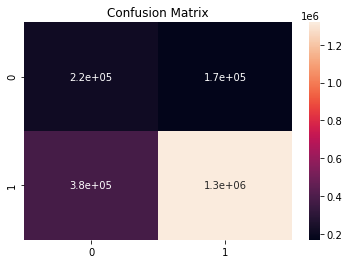

In [9]:
print('The accuracy is:', metrics.accuracy_score(y_test, prediction))
print("\n")
print("Classification Report:")
print(metrics.classification_report(y_test, prediction))

sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.title("Confusion Matrix")
plt.show()

In [10]:
model_file_name = "loan-trained-xgboost-model"
model._Booster.save_model(model_file_name)

In [11]:
!tar czvf model.tar.gz $model_file_name

loan-trained-xgboost-model


In [12]:
joblib.dump(model, '20210429141500_cfpb_loan.joblib')

['20210429141500_cfpb_loan.joblib']

As we can see on the classification report, as well as the confusion matrix, the classifier is fairly accurate, but outputs a number of false positive and false  negative values as well.

# Conclusion
The accuracy of the binary classifier is not great, but it could possibly be improved if more useful features were added on the dataset or by exploring the performance of other algorithms and techniques. 
